In [6]:
import QBOOST as qb
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from funcsigs import signature
import xgboost as xgb


In [2]:
data = pd.read_csv('train.csv')
y = data['target']
x = data.drop(['target', 'ID_code'], axis=1)

In [3]:
# Using PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(x)
x_pca = pca.transform(x)

In [4]:
# Reducing the size of the data
x, _, y, _ = train_test_split(x_pca, y, test_size=0.5, random_state=42)

In [5]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
#XGBoost

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

XGBoost
Accuracy:  0.90025


ValueError: x is neither increasing nor decreasing : [0 0 0 ... 0 0 0].

In [ ]:
# Predicting the test set results
y_score = bst.predict(dtest)
y_pred = np.where(y_score > 0.5, 1, 0)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

# Calculating the AUC
fpr, tpr, thresholds = precision_recall_curve(y_test, y_pred)
auc(fpr, tpr)

In [9]:
# Finding the best params for the knn classifier

params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params, cv=5)
clf.fit(x_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

best_number_of_neighbors = clf.best_params_['n_neighbors']

{'n_neighbors': 17}
0.90015


<Axes: >

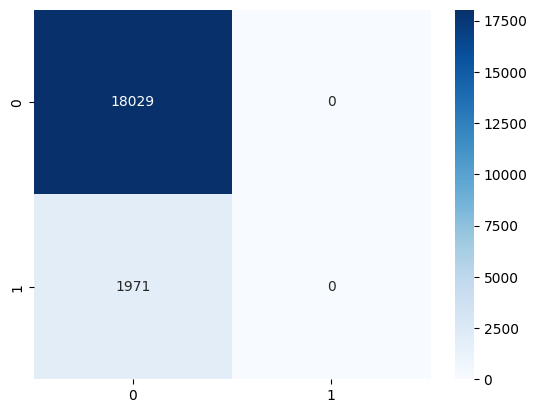

In [56]:
# predicting the test set
knn = KNeighborsClassifier(n_neighbors=best_number_of_neighbors)
knn.fit(x_train, y_train)
y_score = knn.predict_proba(x_test)[:, 1]
y_pred = knn.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

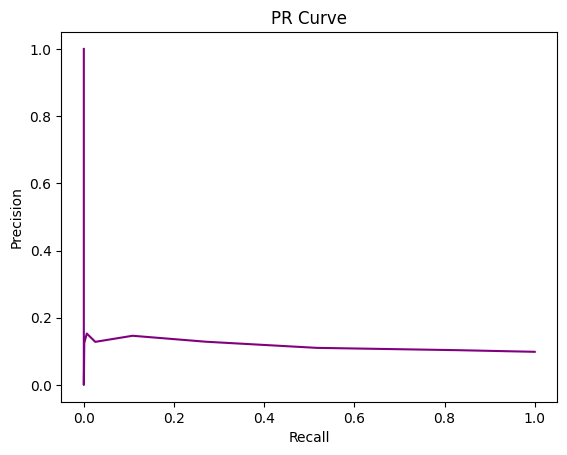

0.11719678512574895

In [57]:
# PR Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()

# AUC
auc(recall, precision)

In [11]:
# Finding the best params for the decision tree classifier

params = {'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, params, cv=5)
clf.fit(x_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

best_depth = clf.best_params_['max_depth']

{'max_depth': 1}
0.9001374999999999


<Axes: >

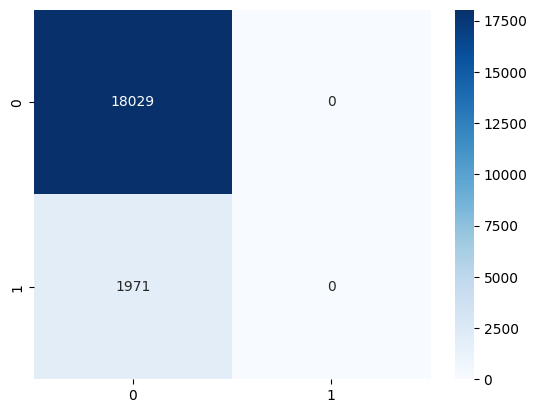

In [60]:
# Training the decision tree classifier
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
y_score = dt.predict_proba(x_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')


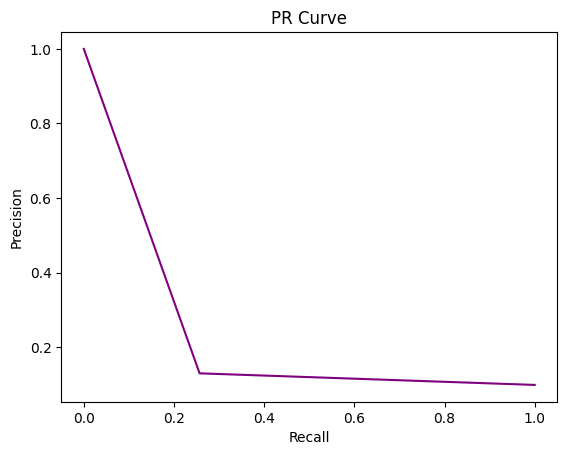

0.22980816979757596

In [61]:
# PR Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()

# AUC
auc(recall, precision)

In [10]:
# Training 30 weak learners knn and decision trees
weak_learners = 30
L = []

for i in range(weak_learners):
    clf = KNeighborsClassifier(n_neighbors=best_number_of_neighbors)
    clf.fit(x_train, y_train)
    L.append(clf)

for j in range(weak_learners):
    clf = DecisionTreeClassifier(max_depth=best_depth)
    clf.fit(x_train, y_train)
    L.append(clf)

In [11]:
w_opt = qb.RGS(L,x_train,y_train,1)
y_pred = qb.PredictRGS(L,w_opt,x_test)

KeyboardInterrupt: 

In [ ]:
w_opt

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

In [ ]:
# Plotting the PR curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))


from sklearn.metrics import precision_recall_curve
from funcsigs import signature

precision, recall, _ = precision_recall_curve(y_test, y_pred)
aucpr_score = auc(recall, precision)

step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
plt.step(recall, precision, color='b', alpha=0.2,
            where='post')   
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve for RGS (n=60, maxd=5): AP={0:0.2f}'.format(average_precision) + ' ' + 'AUCPR={0:0.2f}'.format(aucpr_score))